In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

# For files download:
import urllib3

# For parseing strings into dataframes
import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO  
    
import scipy

# Supress warnings, which happen mostly because of outdated numpy
import warnings
warnings.simplefilter("ignore")

In [2]:
from lib import *

In [3]:
if not os.path.exists('./data'):
    os.mkdir('./data')

### Bintu et al. data

Link to the paper: https://science.sciencemag.org/content/362/6413/eaau1783 

Method: STORM and difraction-limited imaging

Resolution: 30 Kb

Regions: 

```
chr21:28000071-29949939 (IMR90,K562,A549,HCT116+/-AUXIN - diffraction limited)

chr21:28000071-29229892 (IMR90 STORM)

chr21:18627714-20577518 (IMR90 - diffraction limited)

chr21:34628096-37117534 (IMR90,K562,A549,HCT116+/-AUXIN - diffraction limited)
```


Genome: hg38

Source: https://github.com/BogdanBintu/ChromatinImaging/tree/master/Data 

Note: There are also files for hg19 genome, but I guess these are the same results posted for another genome. 

note on definition of the contact from the paper: 
```
"Contact between two chromatin segments was defined as
their center-to-center distance between smaller than 150 nm in our diffraction-limited multiplexed
imaging data. The contact probability was defined for each pair of 30 kb segments as the fraction of
chromosomes satisfying this requirement"
```
```
"Two segments were considered contacting in diffraction-limited
images if their spatial inter-distance is less than 150 nm. Similarly, in the spatial-overlap analysis
of STORM images, two segments were considered contacting if their fraction-of-overlap value,
as defined above, was greater than 0.1. These threshold values were selected to be smaller than,
or comparable to, the average values between the consecutive segments which are intrinsically
contacting or overlapping as they are polymerically connected."
```

In [6]:
path = 'https://raw.githubusercontent.com/BogdanBintu/ChromatinImaging/master/Data/'
files_list = [
    'HCT116_chr21-28-30Mb_6h auxin.csv',  # Take 10 cells
    'HCT116_chr21-28-30Mb_untreated.csv', # Take 10 cells
#     'HCT116_chr21-34-37Mb_6h auxin.csv',
#     'HCT116_chr21-34-37Mb_auxin_cellDiv.csv',
#     'A549_chr21-28-30Mb.csv',
#     'HCT116_chr21-34-37Mb_untreated.csv',
#     'IMR90_chr21-18-20Mb.csv',
#     'IMR90_chr21-28-30Mb.csv',
#     'IMR90_chr21-28-30Mb_cell cycle.csv',
#     'K562_chr21-28-30Mb.csv'
]

In [8]:
resolution = 30_000
distance_threshold = 150

for f in files_list:
    
    # Read the file content
    link = os.path.join(path, f)
    http_pool = urllib3.connection_from_url(link)
    r = http_pool.urlopen('GET', link)
    data = r.data.decode('utf-8')
    
    # Read the dataframe with 3D coordinates: 
    df = pd.read_csv(StringIO(data), sep=",", skiprows=1)
    
    # Create table of genomic segments: 
    region = f.split('_')[1].split('-')
    segments = np.sort(np.unique(df['Segment index']))
    segments_table = pd.DataFrame({'Segment index': segments,
                                  'chrom': [region[0] for x in segments], 
                                  'start': [int(region[1])*1e6 + i*resolution for i in range(len(segments))]})
    segments_table['end'] = segments_table['start'] + resolution
    segments_table = segments_table.set_index('Segment index')
    
    cells = np.sort(np.unique(df['Chromosome index']))
    for cell in np.random.choice(cells, 10): # pick 10 random cells
        
        coordinates = df.loc[df['Chromosome index']==cell, ['X', 'Y', 'Z']].values # 3D coordinates
        n_dots = coordinates.shape[0] # Number of bins in the analysis
        dist_mtx = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(coordinates, metric='euclidean'))
        
        # Construct data structure: 
        experiment = ImagingExperiment(dist_mtx, {'n_dots' : n_dots, 
                                                  'author' : "Bintu2018", 
                                                  'region' : f.split('_')[1].split('.')[0], 
                                                  'cell_index' : cell,
                                                  'resolution': 30000,
                                                 'file': f,
                                                 'cell_line': f.split('/')[-1].split('_')[0]})
        
        # Calculate distance matrix and contacts:
        experiment.convert_to_contacts(threshold=distance_threshold)
        experiment.annotate_contacts(segments_table)
        experiment.annotate_distances(segments_table)
        
        # Write the output
        experiment.save_contacts('./data/contacts_{author}_{cell_line}_region-{region}_cell-{cell_index}.tsv')
        experiment.save_distances('./data/distances_{author}_{cell_line}_region-{region}_cell-{cell_index}.tsv')

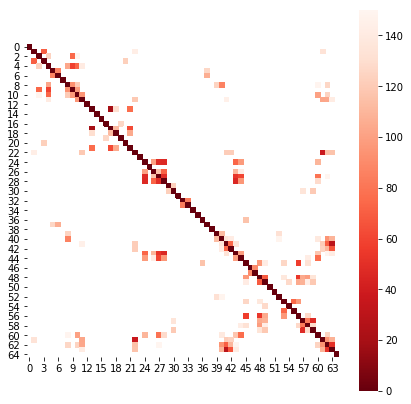

In [6]:
# Visualize some cell:
dist_matrix = experiment.dist_matrix.copy()
dist_matrix[dist_matrix>150] = np.nan
plt.figure(figsize=[7, 7])
sns.heatmap(dist_matrix, cmap='Reds_r', square=True)

In [7]:
experiment.metadata

{'n_dots': 65,
 'author': 'Bintu2018',
 'region': 'chr21-28-30Mb',
 'cell_index': 1645,
 'resolution': 30000,
 'file': 'HCT116_chr21-28-30Mb_untreated.csv',
 'cell_line': 'HCT116'}

### Su et al. data

Link to the paper: https://www.sciencedirect.com/science/article/abs/pii/S0092867420309405 

Method: multiplexed error-robust fluorescence in situ hybridization (MERFISH)

Resolution: 

Regions: 

Genome: 

Source: https://zenodo.org/record/3928890#.YRKNadMza3J 

Note, from README.md:

```
"
1.	chromosome21.tsv - containing the 3D positions of the genomic loci across chromosome 21 measured using the sequential hybridization approach, separated for each imaged chromosomal copy. In separate columns, we also indicate the genes measured within each locus, their transcriptional states and the 3D positions of the corresponding 5kb chromatin segments around their transcription starts sites.

2.	chromosome21-cell_cycle.tsv - a replicate containing the 3D positions of the genomic loci across chromosome 21 measured using the sequential hybridization approach, separated for each imaged chromosomal copy. In separate columns, we also indicate the genes measured within each locus, their transcriptional states and the 3D positions of the corresponding 5kb chromatin segment around the transcription starts sites. In this replicate, we also imaged cell-cycle markers and indicated the cell cycle phases of the cells in a separate column.

3.	chromosome2.tsv - containing the 3D positions of the genomic loci across chromosome 2 measured using the sequential hybridization approach, separated for each imaged chromosomal copy. 

4.	genomic-scale.tsv - containing the 3D positions of the genomic loci measured in the genome-scale measurements using the DNA-MERFISH approach, separated for each homologous copy of each chromosome in each single cell. In a separate column, we indicate the distances from the imaged loci to the nuclear lamina. 
3 replicate experiments are included in this file.

5.	genomic-scale-with transcription and nuclear bodies.tsv - containing the 3D positions of the genomic loci measured in the genome-scale measurements using the DNA-MERFISH approach, separated for each homologous copy of each chromosome in each single cell. In separate columns, we indicate for each locus whether the genes measured within it are actively transcribing and the distances from the locus to the nuclear lamina, the nearest nuclear speckle and the nearest nucleolus.
2 replicate experiments are included in this file.

6.	genomic-scale-amanitin.tsv - containing the 3D positions of the genomic loci measured in the genome-scale measurements using the DNA-MERFISH approach, separated for each homologous copy of each chromosome in each single cell for cells treated with α-amanitin. In separate columns, we indicate for each locus its distances to the nuclear lamina, the nearest nuclear speckle and nearest nucleolus where available.
2 replicate experiments are included in this file. We only measured the nuclear speckles and nucleoli in the first experiment.


We also included a Chromosome 2 p-arm replicate data file as described below, which has not been included in the Chromosome 2 p-arm analyses shown in the paper:

chromosome2_p-arm_replicate.tsv - containing the 3D positions of the genomic loci across the p-arm of Chromosome 2 measured using the sequential hybridization approach, separated for each imaged chromosomal copy. 
"
```

On selection of distance threshold:
```
 The Pearson correlation coefficient remained high for a wide range of cutoff distances but peaked at 0.87 when the cutoff distance was ~400–600 nm (Figure S1J). We thus chose 500 nm as the cutoff
distance to generate proximity frequency maps throughout this work.
```



In [4]:
path = 'https://zenodo.org/record/3928890/files/{file}?download=1'
files_list = [
    'chromosome2.tsv',
#     'chromosome21-cell_cycle.tsv',
    'chromosome21.tsv',
#     'chromosome2_p-arm_replicate.tsv',
#     'genomic-scale-amanitin.tsv',
#     'genomic-scale-with%20transcription%20and%20nuclear%20bodies.tsv',
#     'genomic-scale.tsv'
]

In [9]:
for f in files_list:
    print(f'Reading table {f}...')
    
    # Read the file content
    link = path.format(file=f)
    http_pool = urllib3.connection_from_url(link)
    r = http_pool.urlopen('GET', link)
    data = r.data.decode('utf-8')
    
    # Read the dataframe with 3D coordinates: 
    df = pd.read_csv(StringIO(data), sep="\t")
    
    df.loc[:, 'chrom'] = [x.split(':')[0] for x in df['Genomic coordinate']]
    # Extract 1 from genomic coordinate to get number divisible by 10:
    df.loc[:, 'start'] = [int(x.split(':')[1].split('-')[0])-1 for x in df['Genomic coordinate']]
    df.loc[:, 'end']   = [int(x.split(':')[1].split('-')[1])-1 for x in df['Genomic coordinate']]
    
    print('Distances downloaded')
    
    cells = np.sort(np.unique(df['Chromosome copy number']))
    picked_cells = np.random.choice(cells, 10) # pick 10 random cells
    for cell in picked_cells: 
        
        print(f'Cell {cell}')    
        df_cell = df.loc[df['Chromosome copy number']==cell, :]
        coordinates    = df_cell.loc[:, ['X(nm)', 'Y(nm)', 'Z(nm)']].values
        segments_table = df_cell.loc[:, ['chrom', 'start', 'end']].reset_index(drop=True)
        n_dots = coordinates.shape[0]
        dist_mtx = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(coordinates, metric='euclidean'))
        
        print('Calculating distances...')
        for distance_threshold in [500, 150]:
            experiment = ImagingExperiment(dist_mtx, {'n_dots' : n_dots, 
                                                    'author' : "Su2020", 
                                                    'region' : f.replace('.', '_').split('_')[0], 
                                                    'cell_index' : cell,
                                                    'file': f,
                                                    'distance_threshold': distance_threshold
                                                     })

            experiment.convert_to_contacts(threshold=distance_threshold)
            experiment.annotate_contacts(segments_table, one_based=False)
            experiment.annotate_distances(segments_table, one_based=False)

            print('Writing experiments...')
            experiment.save_contacts(  './data/contacts_th{distance_threshold}nm_{author}_region-{region}_cell-{cell_index}.tsv')
            experiment.save_distances('./data/distances_th{distance_threshold}nm_{author}_region-{region}_cell-{cell_index}.tsv')

#### Selection of distance threshold for Su et al.

The authors suggest very large threshold which retains tens of thousands of contacts. For simulations, it is reasonable to reduce the distance threshold. For example, 150 nm is used in other works, and results in ~contacts per chromosome. 

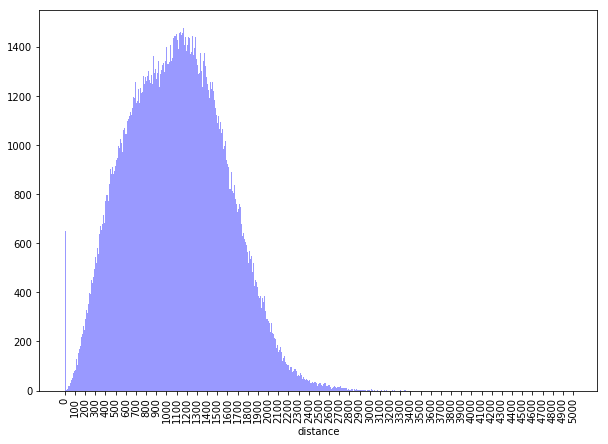

In [6]:
plt.figure(figsize=[10,7])
sns.distplot(experiment.dist_dataframe.distance, color='blue', bins=np.arange(0,5000,10), kde=False)
plt.xticks(np.arange(0, 5100, 100), rotation=90)
plt.show()

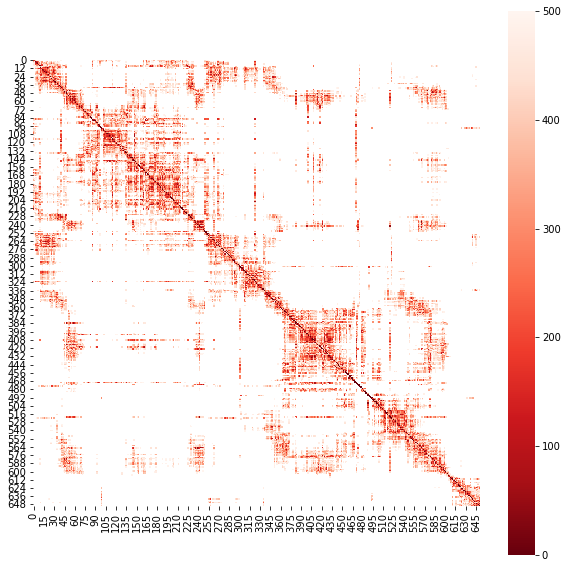

In [7]:
# Visualize some cell with 500-nm threshold:

experiment.convert_to_contacts(threshold=500)

dist_matrix = experiment.dist_matrix.copy()
dist_matrix[dist_matrix>500] = np.nan
plt.figure(figsize=[10, 10])
sns.heatmap(dist_matrix, cmap='Reds_r', square=True)

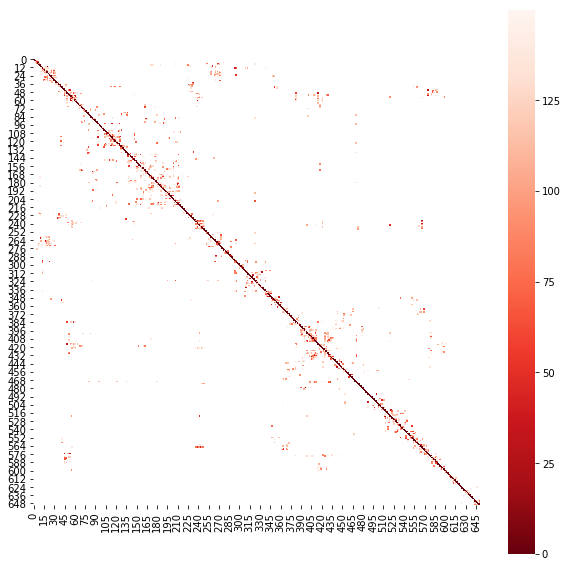

In [8]:
# Visualize some cell with 150-nm threshold:

experiment.convert_to_contacts(threshold=150)

dist_matrix = experiment.dist_matrix.copy()
dist_matrix[dist_matrix>150] = np.nan
plt.figure(figsize=[10, 10])
sns.heatmap(dist_matrix, cmap='Reds_r', square=True)